In [1]:
# Data processing
import numpy as np
import pandas as pd
import xarray as xr
import iris
import iris.pandas
import warnings
warnings.filterwarnings('ignore', module='iris')
from pathlib import Path
import dateutil.parser
from datetime import datetime, timedelta
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
# Scientific parameters
M_air = 28.97 # molar mass of dry air [g mol-1]
# Coefficients to convert mass mixing ratio to volume mixing ratio
coeff_c2h6 = (M_air/30.0690)*1e12 # Ethane_WAS
coeff_c3h8 = (M_air/44.0956)*1e12 # Propane_WAS
coeff_nc4h10 = (M_air/58.1222)*1e12 # n-Butane_WAS
coeff_ic4h10 = (M_air/58.1222)*1e12 # i-Butane_WAS
coeff_nc5h12 = (M_air/72.1488)*1e12 # n-Pentane_WAS
coeff_ic5h12 = (M_air/72.1488)*1e12 # i-Pentane_WAS
coeff_meono2 = (M_air/77.0394)*1e12 # MeONO2_WAS
coeff_sbuono2 = (M_air/119.1192)*1e12 # 2-BuONO2_WAS or sBuONO2
coeff_n2peono2 = (M_air/133.1457)*1e12 # 2-PenONO2_WAS or n2PeONO2 or nPeBONO2
coeff_n3peono2 = (M_air/133.1457)*1e12 # 3-PenONO2_WAS or n3PeONO2 or nPeCONO2
coeff_ipeono2 = (M_air/133.1457)*1e12 # 3-Methyl-2-BuONO2_WAS or iPeONO2 or iPeBONO2
# Plotting parameters
plt.rcParams['mathtext.default'] = 'regular'
savefig = False
# Species names
str_c2h6 = '$C_2H_6$'; str_c3h8 = '$C_3H_8$'
str_nc4h10 = '$nC_4H_{10}$'; str_ic4h10 = '$iC_4H_{10}$'
str_nc5h12 = '$nC_5H_{12}$'; str_ic5h12 = '$iC_5H_{12}$'
str_meono2 = '$MeONO_2$'; str_sbuono2 = '2-$BuONO_2$'
str_n2peono2 = '2-$PenONO_2$'; str_n3peono2 = '3-$PenONO_2$'; str_ipeono2 = '3-Methyl-2-$BuONO_2$'

#### Read data

In [2]:
path_to_atom = Path('../../../obs/ATom/nc/data')
# Select flights
fname_atom_flight = 'MER-WAS_DC8_201702*.nc'
# Read ATom data
atom_dsinf = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), decode_times=True)
atom_dsmms = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), group='MMS', decode_cf=True)
atom_dswas = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), group='WAS', decode_cf=True)

In [3]:
# Read precalculated UKCA trajectories
ukca_run_name = 'az166a'
compared_common_id = '170201_170221_1702_merge'
path_to_prcd = Path('../processed') / ukca_run_name
traj_c2h6 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_c2h6.nc')
traj_c3h8 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_c3h8.nc')
traj_nc4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_nc4h10.nc')
traj_ic4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_ic4h10.nc')
traj_nc5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_nc5h12.nc')
traj_ic5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_ic5h12.nc')
traj_meono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_meono2.nc')
traj_sbuono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_sbuono2.nc')
traj_n2peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_n2peono2.nc')
traj_n3peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_n3peono2.nc')
traj_ipeono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_traj_ipeono2.nc')

In [4]:
# Path to figures
path_to_figs = Path('../../../results') / ukca_run_name / compared_common_id
path_to_figs.mkdir(exist_ok=True) # create a new folder if it doesn't exist
print(compared_common_id)

170201_170221_1702_merge


#### Time series of concentrations along flight track

In [5]:
# Extract datetimes from ATom data
atom_datetime = atom_dsinf.time.values.astype('<M8[us]').astype(datetime)
atom_date_strt = atom_datetime[0]
atom_date_stop = atom_datetime[-1]
# Time series and cross section plotting parameters
if compared_common_id == '160801_160823_1608_merge':
    flght_separators = [147, 276, 427, 572, 735, 894, 1055, 1212, 1329] # manually select indices of flight start times in a merge
    slct_time_inds = np.arange(0, atom_dsinf.time.shape[0], 250) # manually choose frequency of datetimes for xticklabels
elif compared_common_id == '170126_170130_1701_merge':
    flght_separators = [141]
    slct_time_inds = np.arange(0, atom_dsinf.time.shape[0], 48)
elif compared_common_id == '170201_170221_1702_merge':
    flght_separators = [165, 324, 477, 633, 776, 928, 1077, 1236] 
    slct_time_inds = np.arange(0, atom_dsinf.time.shape[0], 250)
slct_time_lbls = [i.strftime('%H:%M\n%d-%m-%Y') for i in atom_dsinf.time.values[slct_time_inds].astype('<M8[us]').astype(datetime)]
print(slct_time_inds, atom_dsinf.time.shape)

[   0  250  500  750 1000 1250] (1363,)


In [6]:
# Convert ATom C2H6, C2H4, C2H2, C3H8, C3H6 to pptvC to match UKCA lumped species, namely C2H6=C2H6+C2H4+C2H2, C3H8=C3H8+C3H6
atom_dswas_c2h6 = atom_dswas['Ethane_WAS']*2 + atom_dswas['Ethene_WAS']*2 + atom_dswas['Ethyne_WAS']*2
atom_dswas_c3h8 = atom_dswas['Propane_WAS']*3 + atom_dswas['Propene_WAS']*3

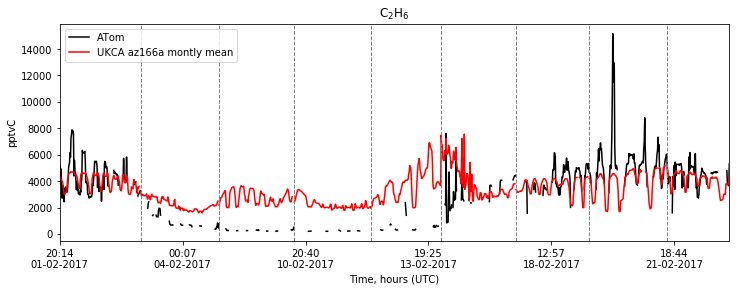

In [8]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas_c2h6, color='k')
ax.plot(traj_c2h6.data.squeeze()*2, color='r')
# common
ax.set_title(f'{str_c2h6}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptvC')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RH_C2.png', bbox_inches='tight')

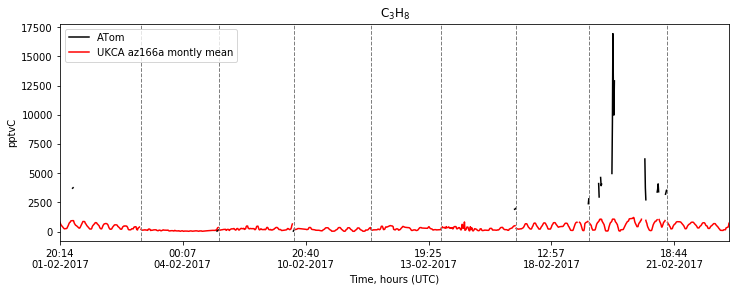

In [9]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas_c3h8, color='k')
ax.plot(traj_c3h8.data.squeeze()*3, color='r')
# common
ax.set_title(f'{str_c3h8}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptvC')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RH_C3.png', bbox_inches='tight')

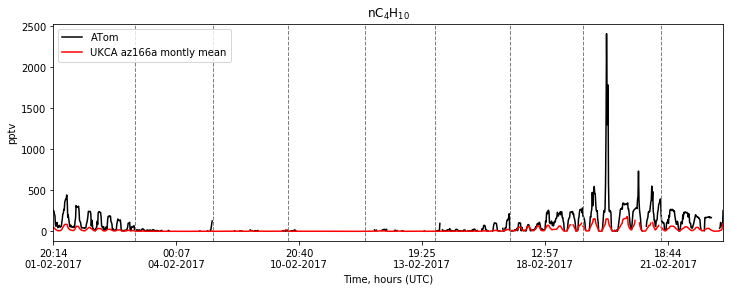

In [10]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['n-Butane_WAS'], color='k')
ax.plot(traj_nc4h10.data.squeeze(), color='r')
# common
ax.set_title(f'{str_nc4h10}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RH_C4n.png', bbox_inches='tight')

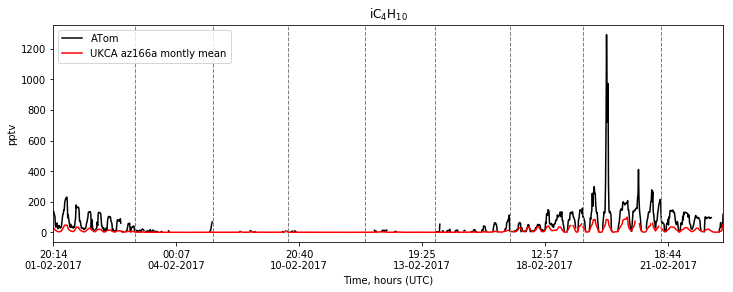

In [11]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['i-Butane_WAS'], color='k')
ax.plot(traj_ic4h10.data.squeeze(), color='r')
# common
ax.set_title(f'{str_ic4h10}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RH_C4i.png', bbox_inches='tight')

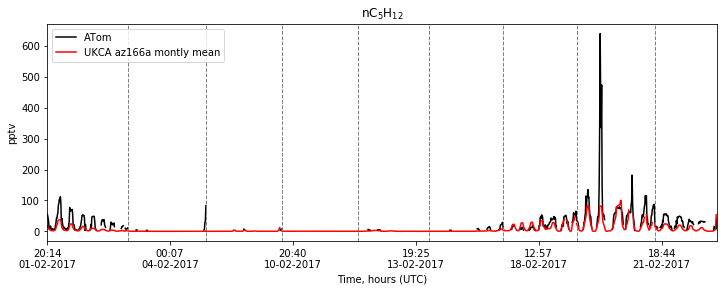

In [12]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['n-Pentane_WAS'], color='k')
ax.plot(traj_nc5h12.data.squeeze(), color='r')
# common
ax.set_title(f'{str_nc5h12}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RH_C5n.png', bbox_inches='tight')

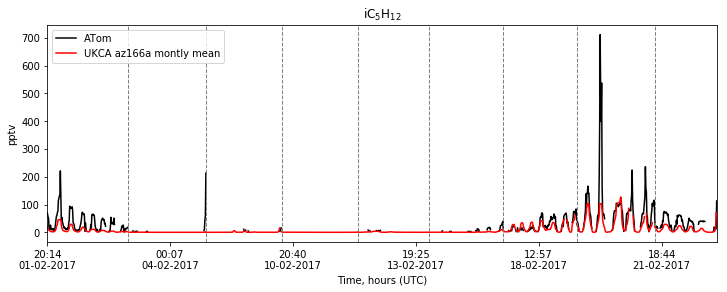

In [13]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['i-Pentane_WAS'], color='k')
ax.plot(traj_ic5h12.data.squeeze(), color='r')
# common
ax.set_title(f'{str_ic5h12}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RH_C5i.png', bbox_inches='tight')

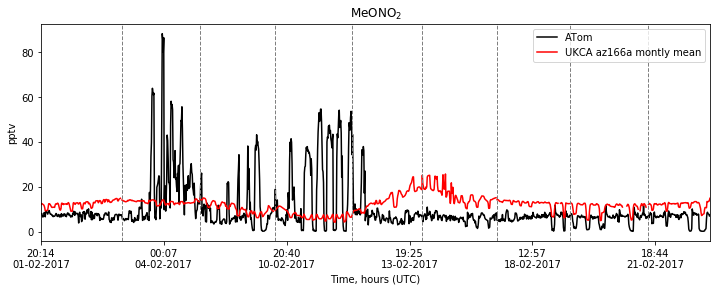

In [14]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['MeONO2_WAS'], color='k')
ax.plot(traj_meono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_meono2}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RONO2_C1.png', bbox_inches='tight')

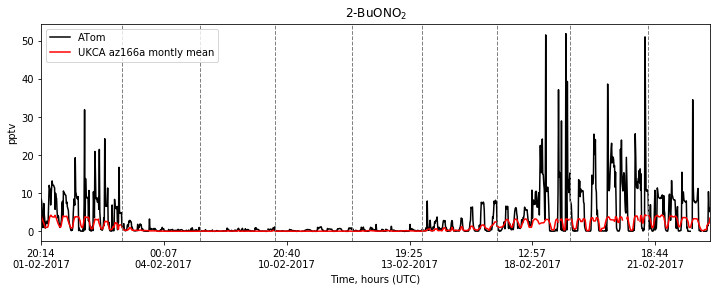

In [15]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['2-BuONO2_WAS'], color='k')
ax.plot(traj_sbuono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_sbuono2}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RONO2_C4s.png', bbox_inches='tight')

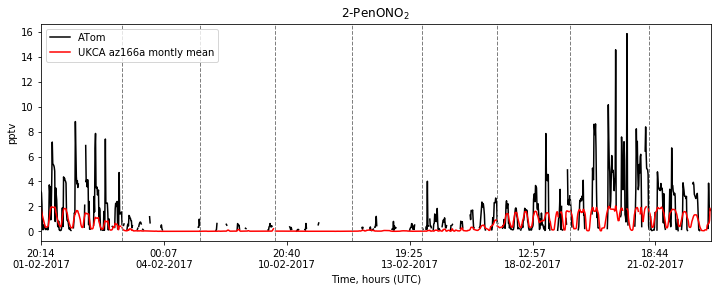

In [16]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['2-PenONO2_WAS'], color='k')
ax.plot(traj_n2peono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_n2peono2}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RONO2_C5nB.png', bbox_inches='tight')

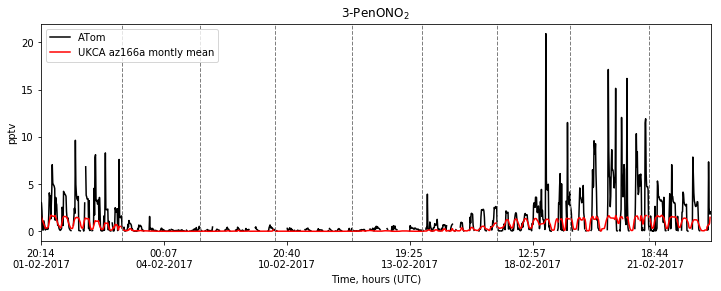

In [17]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['3-PenONO2_WAS'], color='k')
ax.plot(traj_n3peono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_n3peono2}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RONO2_C5nC.png', bbox_inches='tight')

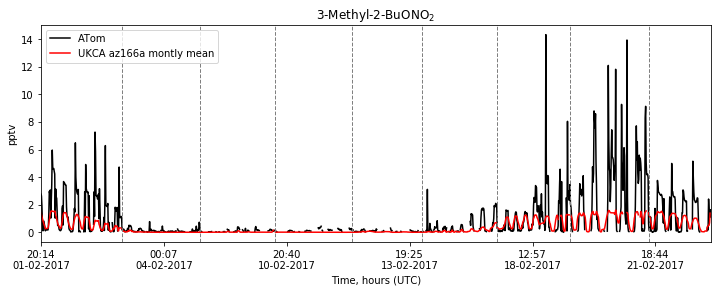

In [18]:
# Plot time series of concentrations along flight track
fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
ax.plot(atom_dswas['3-Methyl-2-BuONO2_WAS'], color='k')
ax.plot(traj_ipeono2.data.squeeze(), color='r')
# common
ax.set_title(f'{str_ipeono2}')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('pptv')
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
ax.legend([f'ATom', f'UKCA {ukca_run_name} montly mean'])
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_ts_RONO2_C5i.png', bbox_inches='tight')

#### Cross section along flight track

In [19]:
# Read precalculated UKCA 2D trajectories
crsc_c2h6 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_c2h6.nc')
crsc_c3h8 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_c3h8.nc')
crsc_nc4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_nc4h10.nc')
crsc_ic4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_ic4h10.nc')
crsc_nc5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_nc5h12.nc')
crsc_ic5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_ic5h12.nc')
crsc_meono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_meono2.nc')
crsc_sbuono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_sbuono2.nc')
crsc_n2peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_n2peono2.nc')
crsc_n3peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_n3peono2.nc')
crsc_ipeono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_ipeono2.nc')

In [20]:
# Convert xarray dataset with observational data to pandas dataframe
atom_c2h6 = atom_dswas_c2h6.to_dataframe(name='Lumped_C2H6_C2H4_C2H2')
atom_c3h8 = atom_dswas_c3h8.to_dataframe(name='Lumped_C3H8_C3H6')
atom_nc4h10 = atom_dswas['n-Butane_WAS'].to_dataframe()
atom_ic4h10 = atom_dswas['i-Butane_WAS'].to_dataframe()
atom_nc5h12 = atom_dswas['n-Pentane_WAS'].to_dataframe()
atom_ic5h12 = atom_dswas['i-Pentane_WAS'].to_dataframe()
atom_meono2 = atom_dswas['MeONO2_WAS'].to_dataframe()
atom_sbuono2 = atom_dswas['2-BuONO2_WAS'].to_dataframe()
atom_n2peono2 = atom_dswas['2-PenONO2_WAS'].to_dataframe()
atom_n3peono2 = atom_dswas['3-PenONO2_WAS'].to_dataframe()
atom_ipeono2 = atom_dswas['3-Methyl-2-BuONO2_WAS'].to_dataframe()

In [21]:
# Find max between maxima and max between minima in ATom and model cross section data for plotting a cross section with two colormaps
cs_c2h6_max = max(np.nanmax(atom_c2h6.values), np.nanmax(crsc_c2h6.data*2))
cs_c3h8_max = max(np.nanmax(atom_c3h8.values), np.nanmax(crsc_c3h8.data*3))
cs_nc4h10_max = max(np.nanmax(atom_nc4h10.values), np.nanmax(crsc_nc4h10.data))
cs_ic4h10_max = max(np.nanmax(atom_ic4h10.values), np.nanmax(crsc_ic4h10.data))
cs_nc5h12_max = max(np.nanmax(atom_nc5h12.values), np.nanmax(crsc_nc5h12.data))
cs_ic5h12_max = max(np.nanmax(atom_ic5h12.values), np.nanmax(crsc_ic5h12.data))
cs_meono2_max = max(np.nanmax(atom_meono2.values), np.nanmax(crsc_meono2.data))
cs_sbuono2_max = max(np.nanmax(atom_sbuono2.values), np.nanmax(crsc_sbuono2.data))
cs_n2peono2_max = max(np.nanmax(atom_n2peono2.values), np.nanmax(crsc_n2peono2.data))
cs_n3peono2_max = max(np.nanmax(atom_n3peono2.values), np.nanmax(crsc_n3peono2.data))
cs_ipeono2_max = max(np.nanmax(atom_ipeono2.values), np.nanmax(crsc_ipeono2.data))

cs_c2h6_min = min(np.nanmax(atom_c2h6.values), np.nanmax(crsc_c2h6.data*2))
cs_c3h8_min = min(np.nanmax(atom_c3h8.values), np.nanmax(crsc_c3h8.data*3))
cs_nc4h10_min = min(np.nanmax(atom_nc4h10.values), np.nanmax(crsc_nc4h10.data))
cs_ic4h10_min = min(np.nanmax(atom_ic4h10.values), np.nanmax(crsc_ic4h10.data))
cs_nc5h12_min = min(np.nanmax(atom_nc5h12.values), np.nanmax(crsc_nc5h12.data))
cs_ic5h12_min = min(np.nanmax(atom_ic5h12.values), np.nanmax(crsc_ic5h12.data))
cs_meono2_min = min(np.nanmax(atom_meono2.values), np.nanmax(crsc_meono2.data))
cs_sbuono2_min = min(np.nanmax(atom_sbuono2.values), np.nanmax(crsc_sbuono2.data))
cs_n2peono2_min = min(np.nanmax(atom_n2peono2.values), np.nanmax(crsc_n2peono2.data))
cs_n3peono2_min = min(np.nanmax(atom_n3peono2.values), np.nanmax(crsc_n3peono2.data))
cs_ipeono2_min = min(np.nanmax(atom_ipeono2.values), np.nanmax(crsc_ipeono2.data))

In [22]:
# Cross section plotting parameters
mrgd_time_inds = np.arange(0,atom_dsinf.time.values.shape[0],1) # merged time indices
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3) #'{:1.1f}'.format(x*1e-3)
# Merge two colormaps: color concentrations present in obs and model using one colormap and obs higher than model using another colormap
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
colors_low = plt.cm.Blues(np.linspace(0,1,128))
colors_high = plt.cm.autumn_r(np.linspace(0,1,128))
colors_stack = np.vstack((colors_low, colors_high))
mrgd_cmap = colors.LinearSegmentedColormap.from_list('merged_cmap', colors_stack)
cs_pc_kwargs = dict(cmap=mrgd_cmap, vmin=0) # model data pcolormesh options
cs_sc_kwargs = dict(cmap=mrgd_cmap, vmin=0, edgecolors='k', linewidth=0.2) # obs data scatter options

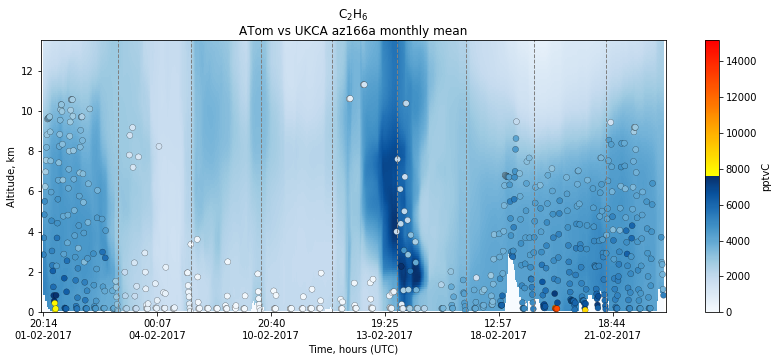

In [26]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_c2h6.coord('altitude').points, crsc_c2h6.data*2, 
                   norm=MidpointNormalize(midpoint=cs_c2h6_min), vmax=cs_c2h6_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_c2h6.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_c2h6_min), vmax=cs_c2h6_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_c2h6}\nATom vs UKCA {ukca_run_name} monthly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RH_C2.png', bbox_inches='tight')

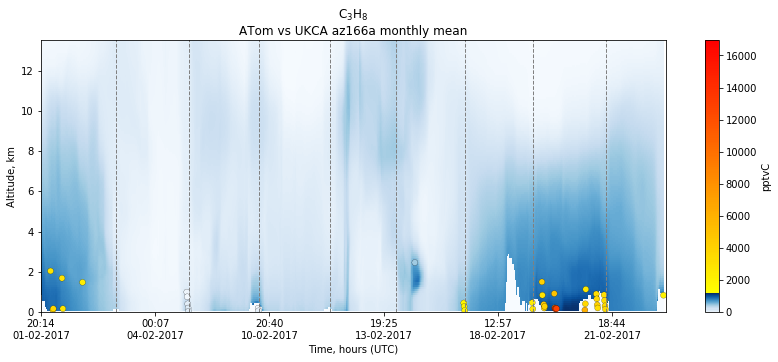

In [35]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_c3h8.coord('altitude').points, crsc_c3h8.data*3, 
                   norm=MidpointNormalize(midpoint=cs_c3h8_min), vmax=cs_c3h8_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_c3h8.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_c3h8_min), vmax=cs_c3h8_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptvC')
# common
ax.set_title(f'{str_c3h8}\nATom vs UKCA {ukca_run_name} monthly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RH_C3.png', bbox_inches='tight')

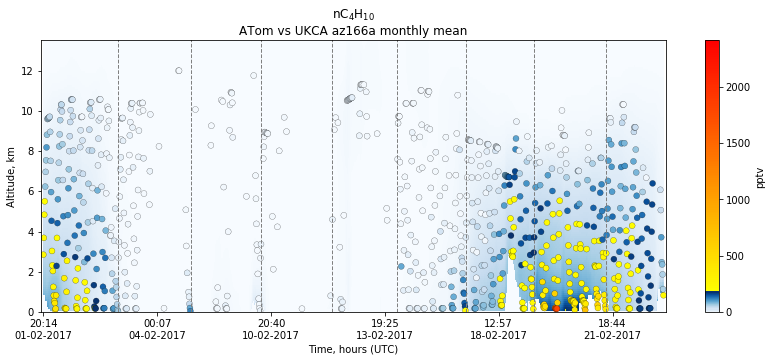

In [28]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_nc4h10.coord('altitude').points, crsc_nc4h10.data, 
                   norm=MidpointNormalize(midpoint=cs_nc4h10_min), vmax=cs_nc4h10_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_nc4h10.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_nc4h10_min), vmax=cs_nc4h10_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_nc4h10}\nATom vs UKCA {ukca_run_name} monthly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RH_C4n.png', bbox_inches='tight')

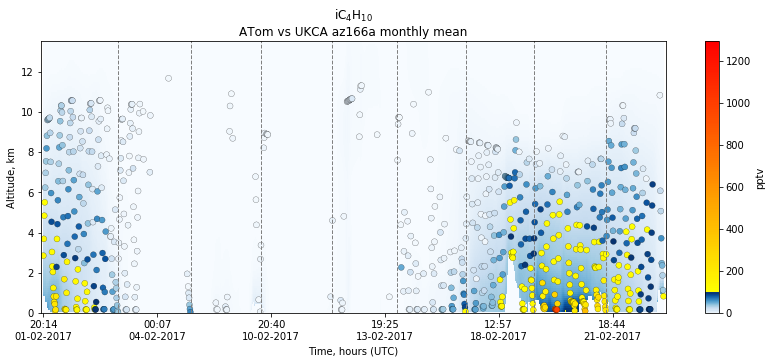

In [29]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_ic4h10.coord('altitude').points, crsc_ic4h10.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_ic4h10_min), vmax=cs_ic4h10_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_ic4h10.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_ic4h10_min), vmax=cs_ic4h10_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_ic4h10}\nATom vs UKCA {ukca_run_name} monthly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RH_C4i.png', bbox_inches='tight')

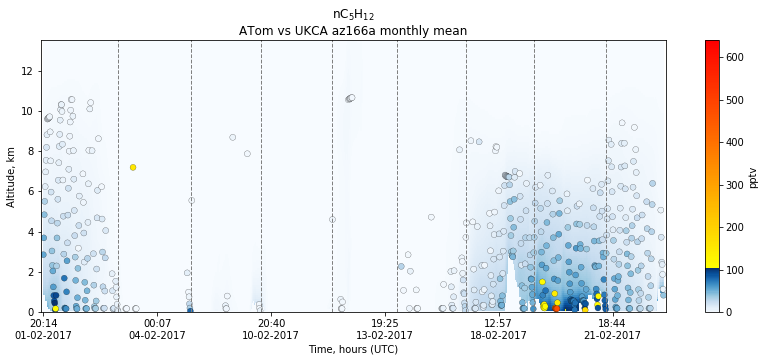

In [30]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_nc5h12.coord('altitude').points, crsc_nc5h12.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_nc5h12_min), vmax=cs_nc5h12_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_nc5h12.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_nc5h12_min), vmax=cs_nc5h12_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_nc5h12}\nATom vs UKCA {ukca_run_name} monthly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RH_C5n.png', bbox_inches='tight')

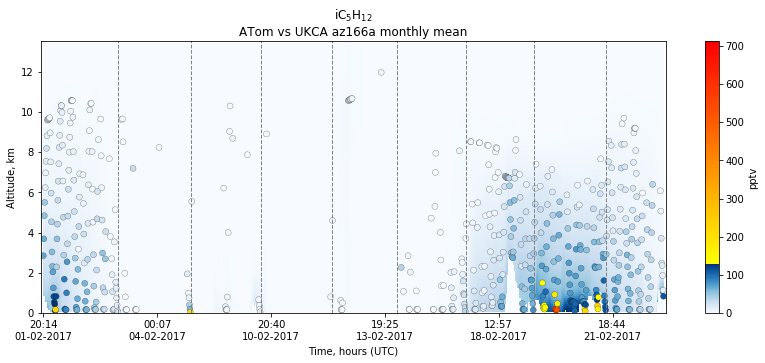

In [31]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_ic5h12.coord('altitude').points, crsc_ic5h12.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_ic5h12_min), vmax=cs_ic5h12_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_ic5h12.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_ic5h12_min), vmax=cs_ic5h12_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_ic5h12}\nATom vs UKCA {ukca_run_name} monthly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RH_C5i.png', bbox_inches='tight')

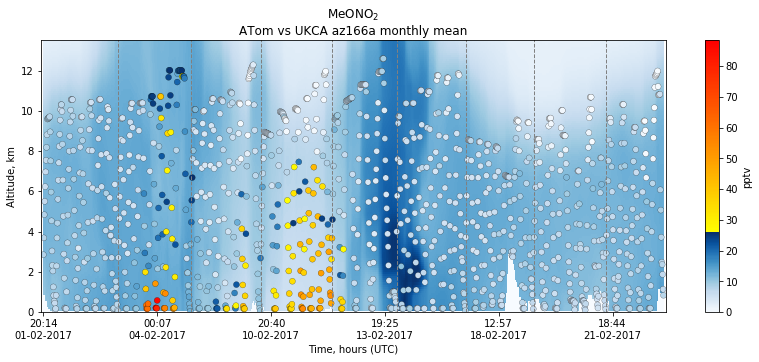

In [32]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_meono2.coord('altitude').points, crsc_meono2.data, 
                   norm=MidpointNormalize(midpoint=cs_meono2_min), vmax=cs_meono2_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_meono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_meono2_min), vmax=cs_meono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_meono2}\nATom vs UKCA {ukca_run_name} monthly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RONO2_C1.png', bbox_inches='tight')

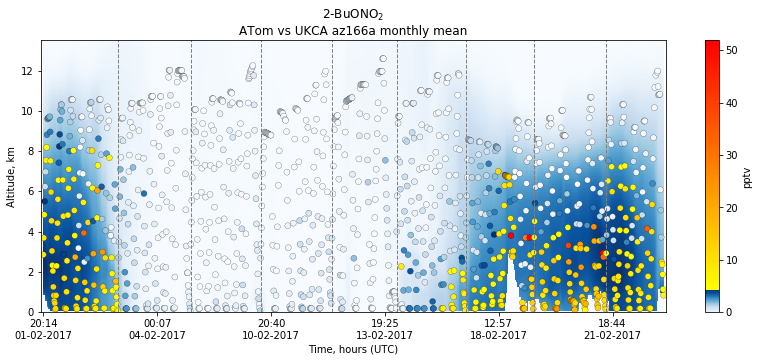

In [33]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_sbuono2.coord('altitude').points, crsc_sbuono2.data, 
                   norm=MidpointNormalize(midpoint=cs_sbuono2_min), vmax=cs_sbuono2_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_sbuono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_sbuono2_min), vmax=cs_sbuono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_sbuono2}\nATom vs UKCA {ukca_run_name} monthly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RONO2_C4s.png', bbox_inches='tight')

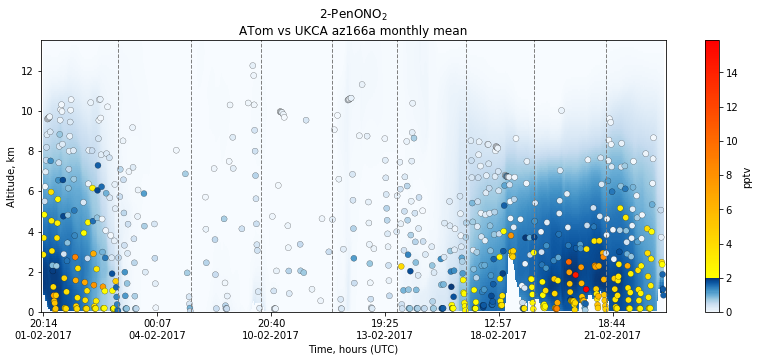

In [34]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_n2peono2.coord('altitude').points, crsc_n2peono2.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_n2peono2_min), vmax=cs_n2peono2_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_n2peono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_n2peono2_min), vmax=cs_n2peono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_n2peono2}\nATom vs UKCA {ukca_run_name} monthly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RONO2_C5nB.png', bbox_inches='tight')

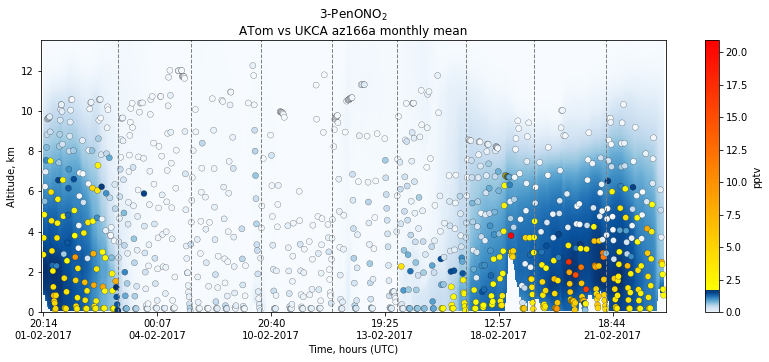

In [36]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_n3peono2.coord('altitude').points, crsc_n3peono2.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_n3peono2_min), vmax=cs_n3peono2_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_n3peono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_n3peono2_min), vmax=cs_n3peono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_n3peono2}\nATom vs UKCA {ukca_run_name} monthly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RONO2_C5nC.png', bbox_inches='tight')

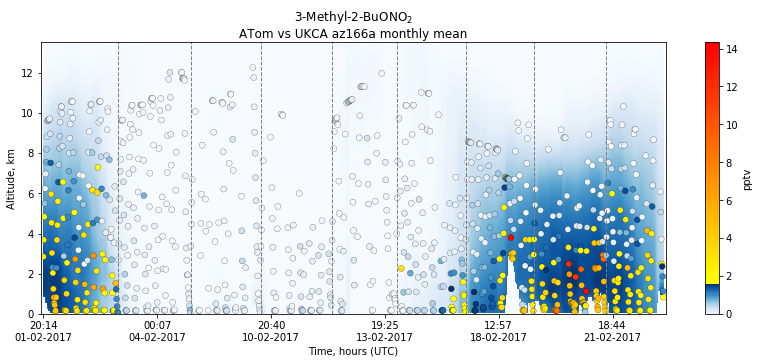

In [37]:
# Plot cross section along flight track
fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
p0 = ax.pcolormesh(mrgd_time_inds, crsc_ipeono2.coord('altitude').points, crsc_ipeono2.data.squeeze(), 
                   norm=MidpointNormalize(midpoint=cs_ipeono2_min), vmax=cs_ipeono2_max, **cs_pc_kwargs)
p1 = ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom_ipeono2.squeeze(), 
                norm=MidpointNormalize(midpoint=cs_ipeono2_min), vmax=cs_ipeono2_max, **cs_sc_kwargs)
fig.colorbar(p0, label='pptv')
# common
ax.set_title(f'{str_ipeono2}\nATom vs UKCA {ukca_run_name} monthly mean')
ax.set_xlabel('Time, hours (UTC)')
ax.set_ylabel('Altitude, km')
ax.set_ylim(0,13500)
ax.set_xticks(slct_time_inds)
ax.set_xticklabels(slct_time_lbls)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0)
for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_cs_RONO2_C5i.png', bbox_inches='tight')

#### Scatter plot data along flight track

In [38]:
# Find max concentration between observational and model trajectory data
sct_max_c2h6 = max(np.nanmax(atom_c2h6.values), np.nanmax(traj_c2h6.data*2))
sct_max_c3h8 = max(np.nanmax(atom_c3h8.values), np.nanmax(traj_c3h8.data*3))
sct_max_nc4h10 = max(np.nanmax(atom_nc4h10.values), np.nanmax(traj_nc4h10.data))
sct_max_ic4h10 = max(np.nanmax(atom_ic4h10.values), np.nanmax(traj_ic4h10.data))
sct_max_nc5h12 = max(np.nanmax(atom_nc5h12.values), np.nanmax(traj_nc5h12.data))
sct_max_ic5h12 = max(np.nanmax(atom_ic5h12.values), np.nanmax(traj_ic5h12.data))
sct_max_meono2 = max(np.nanmax(atom_meono2.values), np.nanmax(traj_meono2.data))
sct_max_sbuono2 = max(np.nanmax(atom_sbuono2.values), np.nanmax(traj_sbuono2.data))
sct_max_n2peono2 = max(np.nanmax(atom_n2peono2.values), np.nanmax(traj_n2peono2.data))
sct_max_n3peono2 = max(np.nanmax(atom_n3peono2.values), np.nanmax(traj_n3peono2.data))
sct_max_ipeono2 = max(np.nanmax(atom_ipeono2.values), np.nanmax(traj_ipeono2.data))

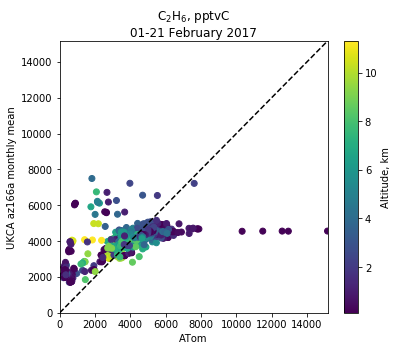

In [39]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_c2h6.squeeze(), traj_c2h6.data.squeeze()*2, c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_c2h6], [0, sct_max_c2h6], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_c2h6}, pptvC\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} monthly mean')
ax.set_xlim(0, sct_max_c2h6)
ax.set_ylim(0, sct_max_c2h6)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RH_C2.png', bbox_inches='tight')

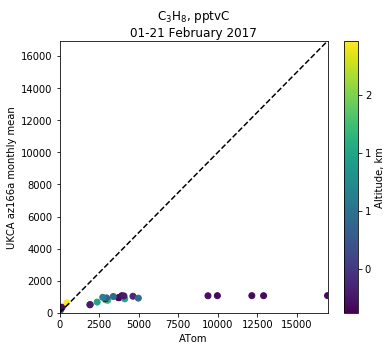

In [40]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_c3h8.squeeze(), traj_c3h8.data.squeeze()*3, c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_c3h8], [0, sct_max_c3h8], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_c3h8}, pptvC\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} monthly mean')
ax.set_xlim(0, sct_max_c3h8)
ax.set_ylim(0, sct_max_c3h8)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RH_C3.png', bbox_inches='tight')

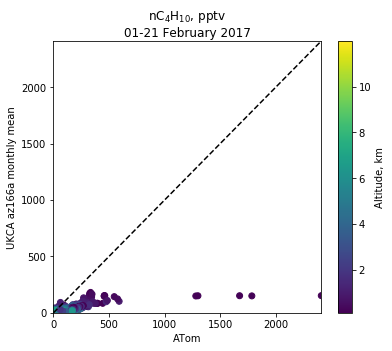

In [41]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_nc4h10.squeeze(), traj_nc4h10.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_nc4h10], [0, sct_max_nc4h10], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_nc4h10}, pptv\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} monthly mean')
ax.set_xlim(0, sct_max_nc4h10)
ax.set_ylim(0, sct_max_nc4h10)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RH_C4n.png', bbox_inches='tight')

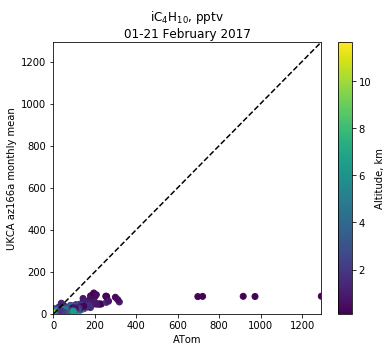

In [42]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_ic4h10.squeeze(), traj_ic4h10.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_ic4h10], [0, sct_max_ic4h10], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_ic4h10}, pptv\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} monthly mean')
ax.set_xlim(0, sct_max_ic4h10)
ax.set_ylim(0, sct_max_ic4h10)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RH_C4i.png', bbox_inches='tight')

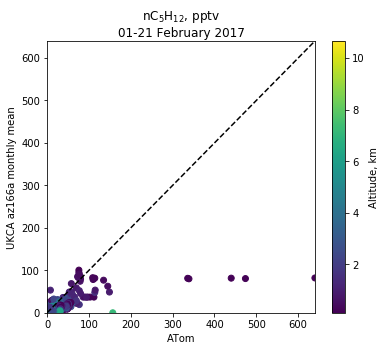

In [43]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_nc5h12.squeeze(), traj_nc5h12.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_nc5h12], [0, sct_max_nc5h12], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_nc5h12}, pptv\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} monthly mean')
ax.set_xlim(0, sct_max_nc5h12)
ax.set_ylim(0, sct_max_nc5h12)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RH_C5n.png', bbox_inches='tight')

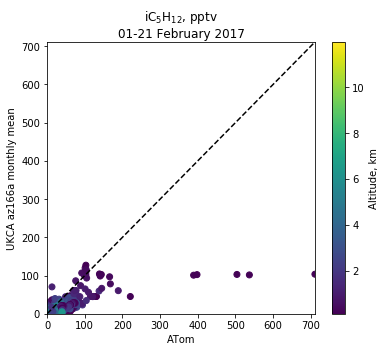

In [44]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_ic5h12.squeeze(), traj_ic5h12.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_ic5h12], [0, sct_max_ic5h12], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_ic5h12}, pptv\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} monthly mean')
ax.set_xlim(0, sct_max_ic5h12)
ax.set_ylim(0, sct_max_ic5h12)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RH_C5i.png', bbox_inches='tight')

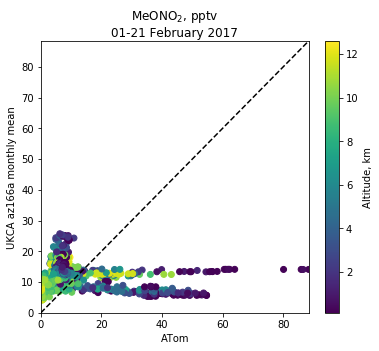

In [45]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_meono2.squeeze(), traj_meono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_meono2], [0, sct_max_meono2], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_meono2}, pptv\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} monthly mean')
ax.set_xlim(0, sct_max_meono2)
ax.set_ylim(0, sct_max_meono2)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RONO2_C1.png', bbox_inches='tight')

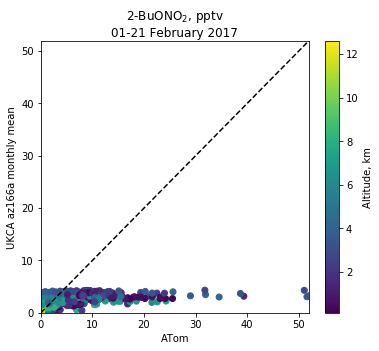

In [46]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_sbuono2.squeeze(), traj_sbuono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_sbuono2], [0, sct_max_sbuono2], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_sbuono2}, pptv\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} monthly mean')
ax.set_xlim(0, sct_max_sbuono2)
ax.set_ylim(0, sct_max_sbuono2)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RONO2_C4s.png', bbox_inches='tight')

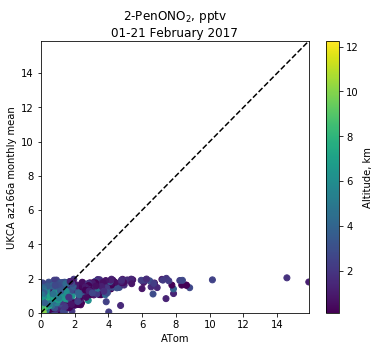

In [47]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_n2peono2.squeeze(), traj_n2peono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_n2peono2], [0, sct_max_n2peono2], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_n2peono2}, pptv\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} monthly mean')
ax.set_xlim(0, sct_max_n2peono2)
ax.set_ylim(0, sct_max_n2peono2)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RONO2_C5nB.png', bbox_inches='tight')

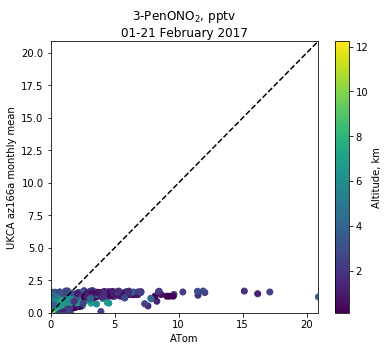

In [48]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_n3peono2.squeeze(), traj_n3peono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_n3peono2], [0, sct_max_n3peono2], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_n3peono2}, pptv\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} monthly mean')
ax.set_xlim(0, sct_max_n3peono2)
ax.set_ylim(0, sct_max_n3peono2)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RONO2_C5nC.png', bbox_inches='tight')

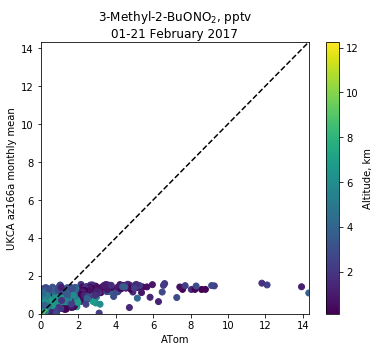

In [49]:
# Plot all flight track data as a scatter plot
fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
p0 = ax.scatter(atom_ipeono2.squeeze(), traj_ipeono2.data.squeeze(), c=atom_dsmms.G_ALT)
ax.plot([0, sct_max_ipeono2], [0, sct_max_ipeono2], color='k', linestyle='--') # 'one-to-one' line
ax.set_title(f'{str_ipeono2}, pptv\n{atom_date_strt.strftime("%d")}-{atom_date_stop.strftime("%d %B %Y")}')
ax.set_xlabel('ATom')
ax.set_ylabel(f'UKCA {ukca_run_name} monthly mean')
ax.set_xlim(0, sct_max_ipeono2)
ax.set_ylim(0, sct_max_ipeono2)
fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_1to1_RONO2_C5i.png', bbox_inches='tight')